In [15]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn import tree

!pip install imblearn
from imblearn.over_sampling import ADASYN

In [16]:
# Import recategorised data
wholedata = pd.read_csv("recategorised_data.csv")
wholedata.describe()

,Entero,Rain24,Rain48,Rain72,RainWA,Wdirection,Wspeed,Solarhours,BeachType,BeachDirection,Entero_level,Wspeed_level,Wdirection_level,on_offshore
count,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,182.596926,2.052960,4.378617,6.878463,13.310040,187.879028,2.702033,6.703718,0.491324,4.221616,0.073872,1.010412,8.029251,0.869113
std,1271.550681,5.678971,9.307389,12.594966,25.209095,90.915915,1.670540,3.849683,0.500049,4.995729,0.261627,0.106303,4.073803,0.861271
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,0.000000,0.000000,0.000000,0.000000,113.000000,1.500000,3.500000,0.000000,1.000000,0.000000,1.000000,5.000000,0.000000
50%,10.000000,0.000000,0.490000,1.460000,2.420000,211.000000,2.400000,7.200000,0.000000,2.000000,0.000000,1.000000,9.000000,1.000000
75%,20.000000,0.980000,4.290000,7.730000,15.160000,253.000000,3.400000,10.000000,1.000000,10.000000,0.000000,1.000000,11.000000,2.000000
max,24196.000000,57.900000,115.250000,127.320000,251.620000,360.000000,14.200000,14.100000,1.000000,15.000000,1.000000,2.000000,15.000000,2.000000


In [17]:
wholedata.head()

,DATE,Entero,Rain24,Rain48,Rain72,RainWA,Wdirection,Wspeed,Solarhours,BeachName,BeachType,BeachDirection,Entero_level,Wspeed_level,Wdirection_level,on_offshore
0,1995-12-16,10.0,9.17,13.67,37.00,59.84,200,1.5,1.8,Clarks,1,15,0,1,9,0
1,1995-12-27,10.0,0.00,0.00,0.33,0.33,230,5.7,8.5,Clarks,1,15,0,1,10,2
2,1995-12-28,10.0,2.50,2.50,2.50,7.50,320,3.6,11.7,Clarks,1,15,0,1,14,1
3,1996-01-07,10.0,0.00,0.00,0.00,0.00,130,4.1,7.9,Clarks,1,15,0,1,6,0
4,1996-01-08,10.0,0.00,0.00,0.00,0.00,100,3.6,4.4,Clarks,1,15,0,1,4,2


In [18]:
wholedata['DATE']=wholedata['DATE'].astype('datetime64')

In [19]:
# put aside test_set for final test 
test_set = wholedata[wholedata['DATE'].dt.year>=2017]
test_set = test_set[test_set['DATE'].dt.year<2018]
test_set = test_set.drop(columns=['Entero','DATE','BeachName'])
test_set = test_set[ ['Entero_level'] + [ col for col in test_set.columns if col != 'Entero_level' ] ]
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73 entries, 215 to 2016
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Entero_level      73 non-null     int64  
 1   Rain24            73 non-null     float64
 2   Rain48            73 non-null     float64
 3   Rain72            73 non-null     float64
 4   RainWA            73 non-null     float64
 5   Wdirection        73 non-null     int64  
 6   Wspeed            73 non-null     float64
 7   Solarhours        73 non-null     float64
 8   BeachType         73 non-null     int64  
 9   BeachDirection    73 non-null     int64  
 10  Wspeed_level      73 non-null     int64  
 11  Wdirection_level  73 non-null     int64  
 12  on_offshore       73 non-null     int64  
dtypes: float64(6), int64(7)
memory usage: 8.0 KB


In [20]:
# train/validation set excluding test_set
data_frame = wholedata[wholedata['DATE'].dt.year<2017]
data_frame = data_frame.sort_values(by=['DATE'])
data_frame = data_frame.drop(columns=['Entero','DATE','BeachName'])
data_frame = data_frame[ ['Entero_level'] + [ col for col in data_frame.columns if col != 'Entero_level' ] ]
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1912 entries, 0 to 1997
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Entero_level      1912 non-null   int64  
 1   Rain24            1912 non-null   float64
 2   Rain48            1912 non-null   float64
 3   Rain72            1912 non-null   float64
 4   RainWA            1912 non-null   float64
 5   Wdirection        1912 non-null   int64  
 6   Wspeed            1912 non-null   float64
 7   Solarhours        1912 non-null   float64
 8   BeachType         1912 non-null   int64  
 9   BeachDirection    1912 non-null   int64  
 10  Wspeed_level      1912 non-null   int64  
 11  Wdirection_level  1912 non-null   int64  
 12  on_offshore       1912 non-null   int64  
dtypes: float64(6), int64(7)
memory usage: 209.1 KB


In [7]:
#AdaBoost = AdaBoostClassifier(n_estimators=400, learning_rate=1,algorithm='SAMME')
AdaBoost = AdaBoostClassifier(learning_rate=0.0001)

BDT with ADASYN (n=10) balanced data ----
input data - ['Rain24' 'Rain48' 'Rain72' 'RainWA' 'Wdirection' 'Wspeed' 'Solarhours'
 'BeachType' 'BeachDirection' 'Wspeed_level' 'Wdirection_level'
 'on_offshore']
Overall accuracy :  0.6752918287937743
Sensitivity :  0.7208333333333337
Specificity :  0.6272


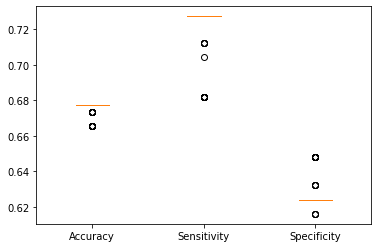

In [8]:
### BDT with ADASYN balanced data
print("BDT with ADASYN (n=10) balanced data ----")
print("input data -", end =" ")
input_data = data_frame.drop(columns=['Entero_level'])
entero_data = data_frame['Entero_level']
c = input_data.columns
print(input_data.columns.values)
# Separate real above and real below data
index_above = (data_frame['Entero_level']==1)
index_below = (data_frame['Entero_level']==0)
input_real_above_data = data_frame[index_above]
input_real_below_data = data_frame[index_below]

# Use real above data form testset above data
testset_above_data = input_real_above_data.drop(columns=['Entero_level'])
water_above_label = input_real_above_data['Entero_level']

# Calculate ratio for train/test for real below data
len_testset = len(input_real_above_data)
ratio = round(len_testset/len(input_real_below_data),2)

# ADASYN
ada = ADASYN(sampling_strategy=1, n_neighbors=10)

# For loop
j=np.zeros(100)
sen=np.zeros(100)
spe=np.zeros(100)
for i in range(100):
    # Generate synthetic sampling data with ADASYN
    data_fake, entero_fake = ada.fit_resample(input_data, entero_data)
    x=pd.DataFrame(data_fake, columns=input_data.columns)
    y=pd.DataFrame(entero_fake, columns=['Entero_level'])
    x['Entero_level']=y['Entero_level'].values
    data_fake_frame=x.query("Entero_level == 1")
    data_fake_frame=data_fake_frame.reset_index(drop=True)
    data_fake_frame.describe()
    
    # Use synthetic data to form trainset above data
    input_fake_data = data_fake_frame.iloc[:,0:-1]
    water_fake_label = data_fake_frame.iloc[:,-1]
    
    # Split the real below data randomly - test set size matches real above data size
    input_real_data = input_real_below_data.drop(columns=['Entero_level'])
    entero_real_data = input_real_below_data.iloc[:,0]
    trainset_below_data, testset_below_data, trainset_below_labels, testset_below_labels = train_test_split(input_real_data, entero_real_data, test_size=ratio, random_state=42)
    
    # Use fake above data plus real below data to form trainset
    trainset_data = np.vstack((input_fake_data, trainset_below_data))
    trainset_labels = np.hstack((water_fake_label, trainset_below_labels))
    
    # Use real above data plus same amount of real below data to form testset
    testset_data = np.vstack((testset_above_data, testset_below_data))
    testset_labels = np.hstack((water_above_label, testset_below_labels))
    
    # Train data normalization
    sc = preprocessing.Normalizer().fit(trainset_data)
    trainset_data = sc.transform(trainset_data)
    testset_data = sc.transform(testset_data)
    
    # Run BDT
    bdt=AdaBoost.fit(trainset_data, trainset_labels)
    cm1 = confusion_matrix(testset_labels,bdt.predict(testset_data))
    total1=sum(sum(cm1))
    #####from confusion matrix calculate accuracy
    j[i] = (cm1[0,0]+cm1[1,1])/total1
    sen[i] = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    spe[i] = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    i=i+1

#End of loop

# Show the KNN result
print ('Overall accuracy : ', j.mean())
print('Sensitivity : ', sen.mean())
print('Specificity : ', spe.mean())
plt.boxplot([j, sen, spe])
plt.xticks([1, 2, 3], ["Accuracy","Sensitivity", "Specificity"])
plt.show()


In [14]:
bdt.staged_score(testset_labels,bdt.predict(testset_data))

<generator object BaseWeightBoosting.staged_score at 0x000001FD7E5C4F20>

BDT model with ADASYN (n=10) balanced data----
Drop: Rain24
input data - ['Rain48' 'Rain72' 'RainWA' 'Wdirection' 'Wspeed' 'Solarhours' 'BeachType'
 'BeachDirection' 'Wspeed_level' 'Wdirection_level' 'on_offshore']
Overall accuracy :  0.6759533073929964
Sensitivity :  0.7153787878787878
Specificity :  0.6343199999999999


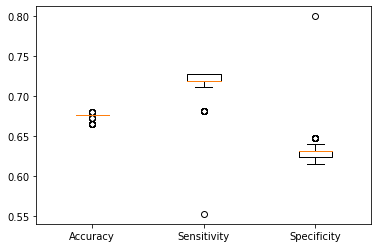

Drop: Rain48
input data - ['Rain24' 'Rain72' 'RainWA' 'Wdirection' 'Wspeed' 'Solarhours' 'BeachType'
 'BeachDirection' 'Wspeed_level' 'Wdirection_level' 'on_offshore']
Overall accuracy :  0.6793774319066148
Sensitivity :  0.7156818181818184
Specificity :  0.6410399999999999


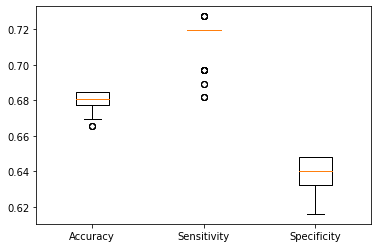

Drop: Rain72
input data - ['Rain24' 'Rain48' 'RainWA' 'Wdirection' 'Wspeed' 'Solarhours' 'BeachType'
 'BeachDirection' 'Wspeed_level' 'Wdirection_level' 'on_offshore']
Overall accuracy :  0.6761478599221792
Sensitivity :  0.7090909090909091
Specificity :  0.6413599999999999


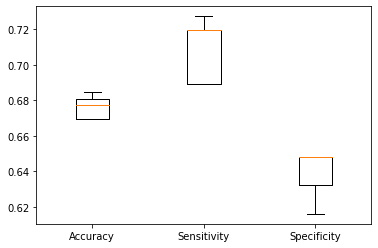

Drop: RainWA
input data - ['Rain24' 'Rain48' 'Rain72' 'Wdirection' 'Wspeed' 'Solarhours' 'BeachType'
 'BeachDirection' 'Wspeed_level' 'Wdirection_level' 'on_offshore']
Overall accuracy :  0.6503112840466926
Sensitivity :  0.6540909090909094
Specificity :  0.6463199999999998


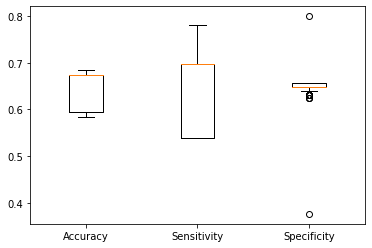

Drop: Wdirection
input data - ['Rain24' 'Rain48' 'Rain72' 'RainWA' 'Wspeed' 'Solarhours' 'BeachType'
 'BeachDirection' 'Wspeed_level' 'Wdirection_level' 'on_offshore']
Overall accuracy :  0.5953307392996109
Sensitivity :  0.5378787878787881
Specificity :  0.6560000000000001


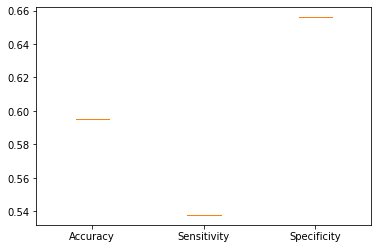

Drop: Wspeed
input data - ['Rain24' 'Rain48' 'Rain72' 'RainWA' 'Wdirection' 'Solarhours' 'BeachType'
 'BeachDirection' 'Wspeed_level' 'Wdirection_level' 'on_offshore']
Overall accuracy :  0.674980544747082
Sensitivity :  0.7192424242424247
Specificity :  0.62824


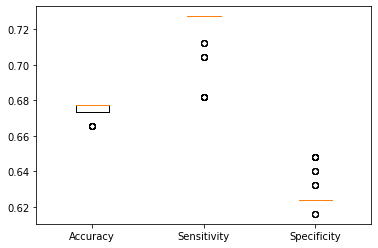

Drop: Solarhours
input data - ['Rain24' 'Rain48' 'Rain72' 'RainWA' 'Wdirection' 'Wspeed' 'BeachType'
 'BeachDirection' 'Wspeed_level' 'Wdirection_level' 'on_offshore']
Overall accuracy :  0.6735408560311287
Sensitivity :  0.7139393939393942
Specificity :  0.6308799999999999


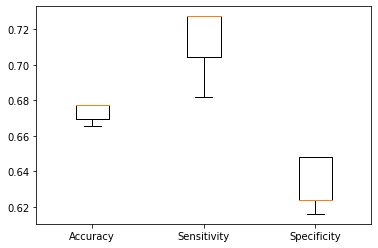

Drop: BeachType
input data - ['Rain24' 'Rain48' 'Rain72' 'RainWA' 'Wdirection' 'Wspeed' 'Solarhours'
 'BeachDirection' 'Wspeed_level' 'Wdirection_level' 'on_offshore']
Overall accuracy :  0.6743968871595334
Sensitivity :  0.7176515151515156
Specificity :  0.62872


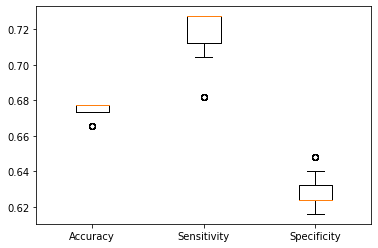

Drop: BeachDirection
input data - ['Rain24' 'Rain48' 'Rain72' 'RainWA' 'Wdirection' 'Wspeed' 'Solarhours'
 'BeachType' 'Wspeed_level' 'Wdirection_level' 'on_offshore']
Overall accuracy :  0.59136186770428
Sensitivity :  0.6175757575757577
Specificity :  0.5636799999999998


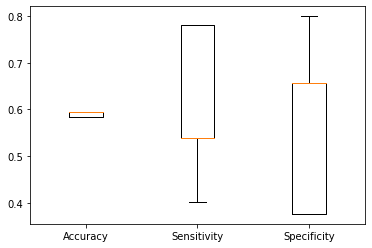

Drop: Wspeed_level
input data - ['Rain24' 'Rain48' 'Rain72' 'RainWA' 'Wdirection' 'Wspeed' 'Solarhours'
 'BeachType' 'BeachDirection' 'Wdirection_level' 'on_offshore']
Overall accuracy :  0.673696498054475
Sensitivity :  0.7174242424242427
Specificity :  0.62752


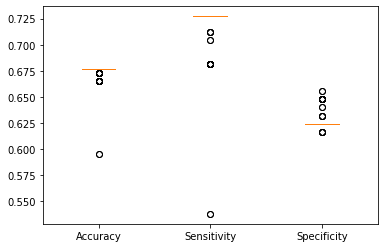

Drop: Wdirection_level
input data - ['Rain24' 'Rain48' 'Rain72' 'RainWA' 'Wdirection' 'Wspeed' 'Solarhours'
 'BeachType' 'BeachDirection' 'Wspeed_level' 'on_offshore']
Overall accuracy :  0.6746303501945526
Sensitivity :  0.7181818181818184
Specificity :  0.6286400000000001


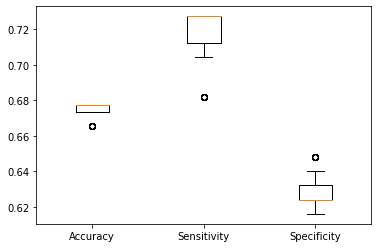

Drop: on_offshore
input data - ['Rain24' 'Rain48' 'Rain72' 'RainWA' 'Wdirection' 'Wspeed' 'Solarhours'
 'BeachType' 'BeachDirection' 'Wspeed_level' 'Wdirection_level']
Overall accuracy :  0.6742801556420236
Sensitivity :  0.7186363636363641
Specificity :  0.6274399999999999


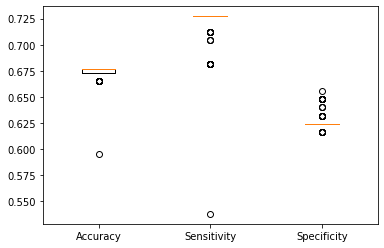

Best sensitivity:  0.7199242424242428 after drop  []
Best accuracy:  0.6793774319066148 after drop  ['Rain48']


In [16]:
### BDT with ADASYN balanced data - drop one parameter each time to compare
print("BDT model with ADASYN (n=10) balanced data----")
best_sen_drop=[]
best_acc_drop=[]
best_acc=j.mean()
best_sen=sen.mean()
for col in c:
    print("Drop:", col)
    input_data = data_frame.drop(columns=[str(col),'Entero_level'])
    entero_data = data_frame['Entero_level']
    print("input data -", end =" ")
    print(input_data.columns.values)
    # Separate real above and real below data
    index_above = (data_frame['Entero_level']==1)
    index_below = (data_frame['Entero_level']==0)
    input_real_above_data = data_frame[index_above]
    input_real_below_data = data_frame[index_below]

    # Use real above data form testset above data
    testset_above_data = input_real_above_data.drop(columns=['Entero_level',str(col)])
    water_above_label = input_real_above_data.iloc[:,0]
    
    # ADASYN
    ada = ADASYN(sampling_strategy=1, n_neighbors=10)

    # For loop
    j=np.zeros(100)
    sen=np.zeros(100)
    spe=np.zeros(100)
    for i in range(100):
        # Generate synthetic sampling data with ADASYN
        data_fake, entero_fake = ada.fit_resample(input_data, entero_data)
        x=pd.DataFrame(data_fake, columns=input_data.columns)
        y=pd.DataFrame(entero_fake, columns=['Entero_level'])
        x['Entero_level']=y['Entero_level'].values
        data_fake_frame=x.query("Entero_level == 1")
        data_fake_frame=data_fake_frame.reset_index(drop=True)
        #data_fake_frame.describe()
    
        # Use synthetic data to form trainset above data
        input_fake_data = data_fake_frame.iloc[:,0:-1]
        water_fake_label = data_fake_frame.iloc[:,-1]
    
        # Split the real below data randomly - test set size matches real above data size
        input_real_data = input_real_below_data.drop(columns=['Entero_level',str(col)])
        entero_real_data = input_real_below_data.iloc[:,0]
        trainset_below_data, testset_below_data, trainset_below_labels, testset_below_labels = train_test_split(input_real_data, entero_real_data, test_size=ratio, random_state=42)
    
        # Use fake above data plus real below data to form trainset
        trainset_data = np.vstack((input_fake_data, trainset_below_data))
        trainset_labels = np.hstack((water_fake_label, trainset_below_labels))
    
        # Use real above data plus same amount of real below data to form testset
        testset_data = np.vstack((testset_above_data, testset_below_data))
        testset_labels = np.hstack((water_above_label, testset_below_labels))
    
        # Train data normalization
        sc = preprocessing.Normalizer().fit(trainset_data)
        trainset_data = sc.transform(trainset_data)
        testset_data = sc.transform(testset_data)
    
        # Run BDT
        bdt=AdaBoost.fit(trainset_data, trainset_labels)
        cm1 = confusion_matrix(testset_labels,bdt.predict(testset_data))
        
        total1=sum(sum(cm1))
        #####from confusion matrix calculate accuracy
        j[i] = (cm1[0,0]+cm1[1,1])/total1
        sen[i] = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        spe[i] = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        i=i+1

    #End of loop

    # Show the KNN result
    print ('Overall accuracy : ', j.mean())
    print('Sensitivity : ', sen.mean())
    print('Specificity : ', spe.mean())
    if sen.mean()>best_sen:
        best_sen=sen.mean()
        best_sen_drop=[col]
    if j.mean()>best_acc:
        best_acc=j.mean()
        best_acc_drop=[col]
    plt.boxplot([j, sen, spe])
    plt.xticks([1, 2, 3], ["Accuracy","Sensitivity", "Specificity"])
    plt.show()
#End of loop

print('Best sensitivity: ',best_sen, 'after drop ', best_sen_drop)
print('Best accuracy: ', best_acc, 'after drop ', best_acc_drop)

In [ ]:
### BDT with ADASYN balanced data - drop two parameters each time to compare
print("BDT model with ADASYN (n=10) balanced data----")
for col1 in c:
    for col2 in c:
        if col1!=col2:
            print("Drop:", col1, col2)
            input_data = data_frame.drop(columns=[str(col1),str(col2),'Entero_level'])
            entero_data = data_frame['Entero_level']
            print("input data -", end =" ")
            print(input_data.columns.values)
            # Separate real above and real below data
            index_above = (data_frame['Entero_level']==1)
            index_below = (data_frame['Entero_level']==0)
            input_real_above_data = data_frame[index_above]
            input_real_below_data = data_frame[index_below]

            # Use real above data form testset above data
            testset_above_data = input_real_above_data.drop(columns=['Entero_level',str(col1),str(col2)])
            water_above_label = input_real_above_data.iloc[:,0]
    
           # ADASYN
            ada = ADASYN(sampling_strategy=1, n_neighbors=10)

            # For loop
            j=np.zeros(100)
            sen=np.zeros(100)
            spe=np.zeros(100)
            for i in range(100):
                # Generate synthetic sampling data with ADASYN
                data_fake, entero_fake = ada.fit_resample(input_data, entero_data)
                x=pd.DataFrame(data_fake, columns=input_data.columns)
                y=pd.DataFrame(entero_fake, columns=['Entero_level'])
                x['Entero_level']=y['Entero_level'].values
                data_fake_frame=x.query("Entero_level == 1")
                data_fake_frame=data_fake_frame.reset_index(drop=True)
                #data_fake_frame.describe()
    
                # Use synthetic data to form trainset above data
                input_fake_data = data_fake_frame.iloc[:,0:-1]
                water_fake_label = data_fake_frame.iloc[:,-1]
    
                # Split the real below data randomly - test set size matches real above data size
                input_real_data = input_real_below_data.drop(columns=['Entero_level',str(col1),str(col2)])
                entero_real_data = input_real_below_data.iloc[:,0]
                trainset_below_data, testset_below_data, trainset_below_labels, testset_below_labels = train_test_split(input_real_data, entero_real_data, test_size=ratio, random_state=42)
    
                # Use fake above data plus real below data to form trainset
                trainset_data = np.vstack((input_fake_data, trainset_below_data))
                trainset_labels = np.hstack((water_fake_label, trainset_below_labels))
    
                # Use real above data plus same amount of real below data to form testset
                testset_data = np.vstack((testset_above_data, testset_below_data))
                testset_labels = np.hstack((water_above_label, testset_below_labels))
    
                # Train data normalization
                sc = preprocessing.Normalizer().fit(trainset_data)
                trainset_data = sc.transform(trainset_data)
                testset_data = sc.transform(testset_data)
    
                # Run BDT
                bdt=AdaBoost.fit(trainset_data, trainset_labels)
                cm1 = confusion_matrix(testset_labels,bdt.predict(testset_data))
                total1=sum(sum(cm1))
                #####from confusion matrix calculate accuracy
                j[i] = (cm1[0,0]+cm1[1,1])/total1
                sen[i] = cm1[1,1]/(cm1[1,0]+cm1[1,1])
                spe[i] = cm1[0,0]/(cm1[0,0]+cm1[0,1])
                i=i+1
    
            #End of loop

        # Show the KNN result
        print ('Overall accuracy : ', j.mean())
        print('Sensitivity : ', sen.mean())
        print('Specificity : ', spe.mean())
        if sen.mean()>best_sen:
            best_sen=sen.mean()
            best_sen_drop=[col1,col2]
        if j.mean()>best_acc:
            best_acc=j.mean()
            best_acc_drop=[col1,col2]
        plt.boxplot([j, sen, spe])
        plt.xticks([1, 2, 3], ["Accuracy","Sensitivity", "Specificity"])
        plt.show()
    #End of loop

print('Best sensitivity: ',best_sen, 'after drop ', best_sen_drop)
print('Best accuracy: ', best_acc, 'after drop ', best_acc_drop)

In [ ]:
# Final model test on separate test-set
input_data = data_frame.drop(columns=['Entero_level'])
input_data = input_data.drop(columns=best_acc_drop)
entero_data = data_frame['Entero_level']
c = input_data.columns
print(input_data.columns.values)

# Separate real above and real below data
index_above = (data_frame['Entero_level']==1)
index_below = (data_frame['Entero_level']==0)
input_real_above_data = data_frame[index_above]
input_real_below_data = data_frame[index_below]

# ADASYN
ada = ADASYN(sampling_strategy=1, n_neighbors=10)

# Generate synthetic sampling data with ADASYN
data_fake, entero_fake = ada.fit_resample(input_data, entero_data)
x=pd.DataFrame(data_fake, columns=c)
y=pd.DataFrame(entero_fake, columns=['Entero_level'])
x['Entero_level']=y['Entero_level'].values
data_fake_frame=x.query("Entero_level == 1")
data_fake_frame=data_fake_frame.reset_index(drop=True)
#data_fake_frame.describe()
    
# Use synthetic data to form trainset above data
input_fake_data = data_fake_frame.iloc[:,0:-1]
water_fake_label = data_fake_frame.iloc[:,-1]
    
# Use fake above data plus real below data to form trainset
trainset_below_data = input_real_below_data.drop(columns=['Entero_level'])
trainset_below_data = trainset_below_data.drop(columns=best_acc_drop)
trainset_below_labels = input_real_below_data.iloc[:,0]
trainset_data = np.vstack((input_fake_data, trainset_below_data))
trainset_labels = np.hstack((water_fake_label, trainset_below_labels))

# Test set
test_set_data = test_set.drop(columns=['Entero_level'])
test_set_data = test_set_data.drop(columns=best_acc_drop)
test_set_labels = test_set['Entero_level']

# Train/test data normalization
sc = preprocessing.Normalizer().fit(trainset_data)
trainset_data = sc.transform(trainset_data)
test_set_data = sc.transform(test_set_data)
        
# Run BDT
bdt=AdaBoost.fit(trainset_data, trainset_labels)

cm1 = confusion_matrix(test_set_labels,bdt.predict(test_set_data))
print("Confusion matrix")
print(cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy=(cm1[0,0]+cm1[1,1])/total1
sen = cm1[1,1]/(cm1[1,0]+cm1[1,1])
spe = cm1[0,0]/(cm1[0,0]+cm1[0,1])

print ('Accuracy : ', accuracy)
print('Sensitivity : ', sen)
print('Specificity : ', spe)